In [1]:
# import the packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from itertools import combinations
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Conceptual exercises

## Training/test error for subset selection

### Generate a data set with $p=20$ features, $n=1000$ observations, and an associated quantitative response vector generated according to the model $Y=Xβ+ϵ$, where $β$ has some elements that are exactly equal to zero.

In [2]:
np.random.seed(1234)

X = np.random.normal(0,5,size = (1000, 20))
epsilon = np.random.normal(size = 1000)
beta = np.append(np.repeat(0,10), np.arange(-5,5))

In [3]:
# beta has some elements equal to zero
beta

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -5, -4, -3, -2, -1,  0,  1,
        2,  3,  4])

In [4]:
Y = np.dot(X, beta) + epsilon

### Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.90, random_state=1234)

### Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size. For which model size does the training set MSE take on its minimum value?

In [6]:
idx = np.arange(20)

opt_models = []; opt_idxes = []
for num in range(1, 21):
    opt_model = []; opt_aic = float('inf'); opt_idx = []
    for feats in combinations(idx, num):
        res = sm.OLS(Y_train, X_train[:, feats]).fit()
        if res.aic < opt_aic:
            opt_aic = res.aic
            opt_model = res
            opt_idx = feats
    opt_models.append(opt_model); opt_idxes.append(opt_idx)

In [7]:
train_mses = []
test_mses = []
for i in range(20):
    model = opt_models[i]; idx = opt_idxes[i]
    train_mses.append(mean_squared_error(Y_train, model.predict(X_train[:,idx])))
    test_mses.append(mean_squared_error(Y_test, model.predict(X_test[:, idx])))

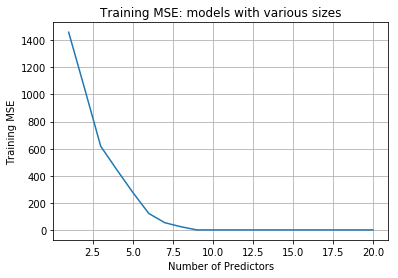

In [8]:
plt.plot(np.arange(20)+1, train_mses)
plt.xlabel("Number of Predictors")
plt.ylabel("Training MSE")
plt.title("Training MSE: models with various sizes")
plt.grid()
plt.show()

The training process reached the minumum MSE at size 20.

### Plot the test set MSE associated with the best model of each size.

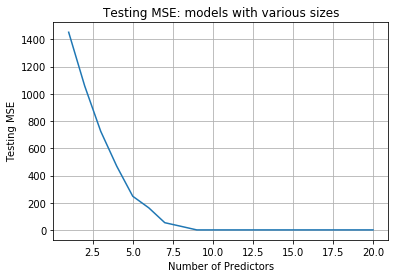

In [9]:
plt.plot(np.arange(20)+1, test_mses)
plt.xlabel("Number of Predictors")
plt.ylabel("Testing MSE")
plt.title("Testing MSE: models with various sizes")
plt.grid()
plt.show()

### For which model size does the test set MSE take on its minimum value? Comment on your results.

The testing MSE takes the minimum value at size 10. This is almost correct compared to our true model, which has 9 non-zero coefficients.

### How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient sizes.

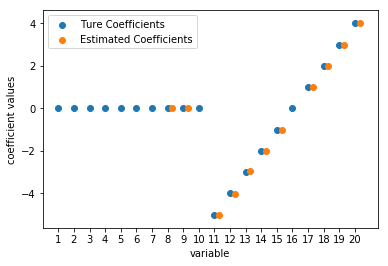

In [10]:
plt.scatter(np.arange(1,21), beta, label='Ture Coefficients')
est_coef = []; var_sel = opt_idxes[10]
for i in range(21):
    if (i-1) in var_sel: est_coef.append(i)
plt.scatter(np.array(est_coef)+0.3, opt_models[10].params, label='Estimated Coefficients')
plt.xticks(np.arange(1,21))
plt.xlabel('variable')
plt.ylabel('coefficient values')
plt.legend()
plt.show()

### Create a plot displaying $\sqrt{\sum_{j=1}^{p}(\beta_{j} - \hat{\beta}_{j}^{r})^{2}}$, for a range of values of $r$, where $\hat{\beta}_{j}^{r}$ is the jth coefficient estimate for the best model containing $r$ coefficients. Comment on what you observe. How does this compare to the test MSE plot from (d)?

In [11]:
vals_r = []
for i in range(20):
    coef_est = np.zeros(20)
    coef_est[list(opt_idxes[i])] = opt_models[i].params
    vals_r.append(np.sqrt(sum((beta-coef_est)**2)))

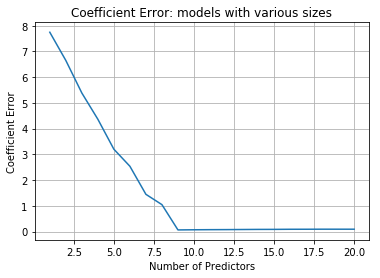

In [12]:
plt.plot(np.arange(20)+1, vals_r)
plt.xlabel("Number of Predictors")
plt.ylabel("Coefficient Error")
plt.title("Coefficient Error: models with various sizes")
plt.grid()
plt.show()

The plot of the coefficient errors look very alike the test set MSE plot.

# Application exercises

In [13]:
gss_train = pd.read_csv("data/gss_train.csv")
gss_test = pd.read_csv("data/gss_test.csv")

## Fit a linear model using least squares on the training set, and report the test MSE.

In [14]:
y_train = gss_train['egalit_scale'].values
x_train = gss_train.drop(['egalit_scale'], axis=1).values
y_test = gss_test['egalit_scale'].values
x_test = gss_test.drop(['egalit_scale'], axis=1).values

In [15]:
model = LinearRegression().fit(x_train, y_train)
pred = model.predict(x_test)
mse_ols = mean_squared_error(y_test, pred)

In [16]:
print("The MSE on the test set is {:.2f}".format(mse_ols))

The MSE on the test set is 63.21


## Fit a ridge regression model on the training set, with λ chosen by 10-fold cross-validation. Report the test MSE.

In [17]:
lambdas = np.logspace(-2, 8, 50)
ridge_mses = []
for l in lambdas:
    m = Ridge(alpha=l)
    mse = np.mean(-cross_val_score(m, x_train, y_train, cv=KFold(10, random_state=0), scoring='neg_mean_squared_error'))
    ridge_mses.append(mse)

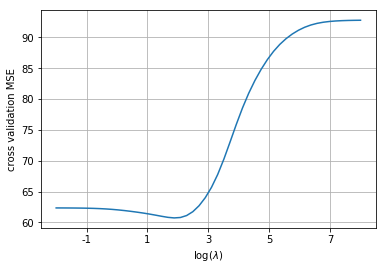

In [18]:
fig, ax = plt.subplots()
ax.plot(lambdas, ridge_mses)
ax.set_xscale('log')
ax.set_xticks([10**(i) for i in range(-1,8,2)])
ax.set_xticklabels([int(np.log10(10**(i)))  for i in range(-1,8,2)])
plt.xlabel('log($\lambda$)')
plt.ylabel('cross validation MSE')
plt.grid()
plt.show()

In [19]:
idx = np.argmin(ridge_mses)
lbd = lambdas[idx]
pred = Ridge(lbd).fit(x_train, y_train).predict(x_test)
mse_ridge = mean_squared_error(y_test, pred)
print("The training set MSE is minimized when λ={:.2f}".format(lbd))
print("The test set MSE={:.2f}".format(mse_ridge))

The training set MSE is minimized when λ=75.43
The test set MSE=62.17


## Fit a lasso model on the training set, with λ chosen by 10-fold cross-validation. Report the test MSE, along with the number of non-zero coefficient estimates.


In [20]:
lambdas = np.logspace(-2, 8, 50)
lasso_mses = []
for l in lambdas:
    m = Lasso(alpha=l)
    mse = np.mean(-cross_val_score(m, x_train, y_train, cv=KFold(10, random_state=0), scoring='neg_mean_squared_error'))
    lasso_mses.append(mse)

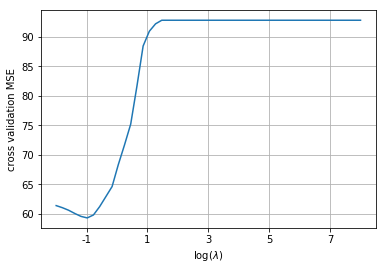

In [21]:
fig, ax = plt.subplots()
ax.plot(lambdas, lasso_mses)
ax.set_xscale('log')
ax.set_xticks([10**(i) for i in range(-1,8,2)])
ax.set_xticklabels([int(np.log10(10**(i)))  for i in range(-1,8,2)])
plt.xlabel('log($\lambda$)')
plt.ylabel('cross validation MSE')
plt.grid()
plt.show()

In [22]:
idx = np.argmin(lasso_mses)
lbd = lambdas[idx]
res = Lasso(lbd).fit(x_train, y_train)
pred = res.predict(x_test)
mse_lasso = mean_squared_error(y_test, pred)
non_zero = 1*(res.coef_!=0).sum()
print("The training set MSE is minimized when λ={:.2f}".format(lbd))
print("The test set MSE={:.2f}".format(mse_lasso))
print("Number of nonzero coefficients: {}".format(non_zero))

The training set MSE is minimized when λ=0.10
The test set MSE=62.80
Number of nonzero coefficients: 23


## Fit an elastic net model on the training set, with α and λ chosen by 10-fold cross-validation. That is, estimate models with α=0,0.1,0.2,…,1 using the same values for lambda across each model. Select the combination of α and λ with the lowest cross-validation MSE. For that combination, report the test MSE along with the number of non-zero coefficient estimates.

In [23]:
import warnings
warnings.filterwarnings('ignore')

alphas = np.arange(0,1.1,0.1)
lambdas = np.logspace(-2,4,30)
elastic_mses = []
opt_lambdas = []
for a in alphas:
    mses = []
    for l in lambdas:
        m = ElasticNet(l, l1_ratio=a)
        mse = np.mean(-cross_val_score(m, x_train, y_train, cv=KFold(10, random_state=0), scoring='neg_mean_squared_error'))
        mses.append(mse)
    elastic_mses.append(min(mses))
    opt_lambdas.append(lambdas[np.argmin(mses)])

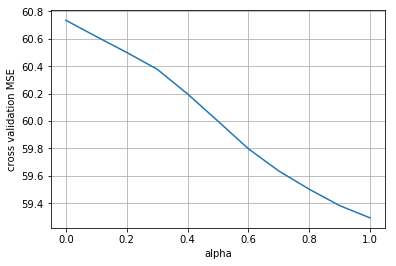

In [24]:
fig, ax = plt.subplots()
ax.plot(alphas, elastic_mses)
plt.xlabel('alpha')
plt.ylabel('cross validation MSE')
plt.grid()
plt.show()

In [25]:
idx = np.argmin(elastic_mses)
alpha = alphas[idx]; lbd = opt_lambdas[idx]
res = ElasticNet(lbd, l1_ratio=alpha).fit(x_train, y_train)
pred = res.predict(x_test)
mse_elastic = mean_squared_error(y_test, pred)
non_zero = 1*(res.coef_!=0).sum()
print("The test set MSE={:.2f}".format(mse_elastic))
print("Number of nonzero coefficients: {}".format(non_zero))

The test set MSE=62.82
Number of nonzero coefficients: 23


## Fit a PCR model on the training set, with $M$ chosen by 10-fold cross-validation. Only use non-binary variables as predictors for this model. Report the test error obtained, along with the value of $M$ selected by cross-validation.

In [26]:
nonbi_col = []
for col in range(x_train.shape[1]):
    if len(np.unique(x_train[:,col]))>2:
        nonbi_col.append(col)

x_train_pca = x_train[:,nonbi_col]

In [27]:
pcs_mses = []
for m in range(1,x_train_pca.shape[1]+1):
    x_reduced = PCA(m).fit_transform(scale(x_train_pca))
    reg = LinearRegression()
    mse = np.mean(-cross_val_score(reg, x_reduced, y_train, cv=KFold(10, random_state=0), scoring='neg_mean_squared_error'))
    pcs_mses.append(mse)

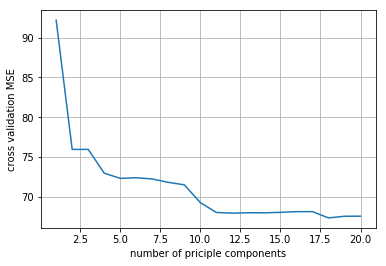

In [28]:
plt.plot(np.arange(1,x_train_pca.shape[1]+1), pcs_mses)
plt.xlabel('number of priciple components')
plt.ylabel('cross validation MSE')
plt.grid()
plt.show()

In [29]:
opt_m = np.argmin(pcs_mses)+1

pca = PCA(opt_m)
x_reduced = pca.fit_transform(scale(x_train_pca))
x_test_pcs = pca.transform(scale(x_test[:,nonbi_col]))
pred = LinearRegression().fit(x_reduced, y_train).predict(x_test_pcs)
mse_pcr = mean_squared_error(y_test, pred)

print("The optimal M = {}".format(opt_m))
print("The MSE on the test set is {:.2f}".format(mse_pcr))

The optimal M = 18
The MSE on the test set is 71.40


## Fit a PLS model on the training set, with M chosen by 10-fold cross-validation. Only use non-binary variables as predictors for this model. Report the test error obtained, along with the value of M selected by cross-validation.

In [30]:
x_train_pls = x_train_pca
x_test_pls = x_test[:,nonbi_col]

In [31]:
pls_mses = []
for m in range(1,x_train_pca.shape[1]+1):
    pls = PLSRegression(n_components=m)
    mse = np.mean(-cross_val_score(pls, x_train_pls, y_train, cv=KFold(10, random_state=0), scoring='neg_mean_squared_error'))
    pls_mses.append(mse)

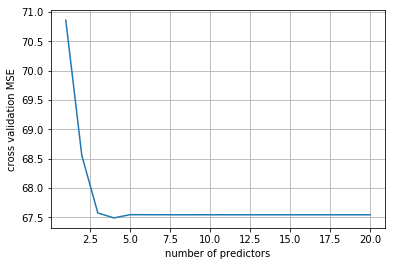

In [32]:
plt.plot(np.arange(1,x_train_pls.shape[1]+1), pls_mses)
plt.xlabel('number of predictors')
plt.ylabel('cross validation MSE')
plt.grid()
plt.show()

In [33]:
opt_m = np.argmin(pls_mses)+1

pls = PLSRegression(opt_m).fit(x_train_pls, y_train)
pred = pls.predict(x_test_pls)
mse_pls = mean_squared_error(y_test, pred)

print("The optimal M = {}".format(opt_m))
print("The MSE on the test set is {:.2f}".format(mse_pls))

The optimal M = 4
The MSE on the test set is 71.98


## Comment on the results obtained. How accurately can we predict an individual’s egalitarianism? Is there much difference among the test errors resulting from these six approaches?

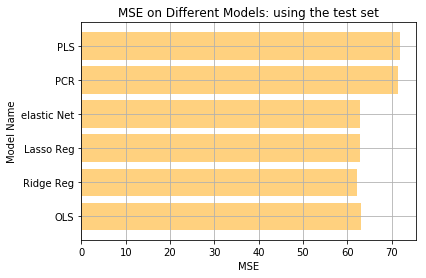

In [34]:
models = ["OLS", "Ridge Reg", "Lasso Reg", "elastic Net", "PCR", "PLS"]
mses = [mse_ols, mse_ridge, mse_lasso, mse_elastic, mse_pcr, mse_pls]

fig, ax = plt.subplots()
ax.grid()
ax.barh(range(len(models)), mses, color = 'orange', alpha = 0.5)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel('MSE'); ax.set_ylabel('Model Name')
ax.set_title('MSE on Different Models: using the test set')
plt.show()

The ridge regression model generated the lowest test MSE value of 62.17. The elastic net, Lasso and OLS model are quite on par the rige model. The PRC and PLS performed worse.